<a href="https://colab.research.google.com/github/Gree606/1DConvolution/blob/main/ASRJasper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Initialize nemo

In [1]:
## Install dependencies## Install NeMo
# BRANCH = 'main'
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

# !pip install --upgrade pip setuptools wheel
# !apt-get update
!apt-get install -y build-essential
!pip install --no-binary :all: mamba-ssm

!pip install nemo-toolkit

!pip install hydra-core omegaconf pytorch-lightning
!pip install lhotse
!pip install jiwer
!pip install pyannote-audio
!pip install webdataset
!pip install fsspec
!pip install datasets
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install text-unidecode
!pip install matplotlib>=3.3.2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
  Using cached mamba_ssm-2.2.4.tar.gz (91 kB)
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
  Using cached jiwer-3.0.5-py3-none-any.whl.metadata (2.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 48.1 MB/s eta 0:00:00
  Using cached pyannote.audio-3.3.2-py2.py3-none-any.whl.metada

2. Dataset download

In [2]:
from google.colab import drive
import glob
import os
import subprocess
import tarfile
import wget

drive.mount('/content/drive')
data_dir = '/content/drive/My Drive/an4'

if not os.path.exists(data_dir):
  os.makedirs(data_dir)

an4_url='https://dldata-public.s3.us-east-2.amazonaws.com/an4_sphere.tar.gz'
print("******")
if not os.path.exists(data_dir + '/an4_sphere.tar.gz'):
    an4_url = 'https://dldata-public.s3.us-east-2.amazonaws.com/an4_sphere.tar.gz'
    an4_path = wget.download(an4_url, data_dir)
    print(f"Dataset downloaded at: {an4_path}")
else:
    print("Tarfile already exists.")
    an4_path = data_dir + '/an4_sphere.tar.gz'

if not os.path.exists(data_dir + '/an4/'):
    # Untar and convert .sph to .wav (using sox)
    tar = tarfile.open(an4_path)
    tar.extractall(path=data_dir)

    print("Converting .sph to .wav...")
    sph_list = glob.glob(data_dir + '/an4/**/*.sph', recursive=True)
    for sph_path in sph_list:
        wav_path = sph_path[:-4] + '.wav'
        cmd = ["sox", sph_path, wav_path]
        subprocess.run(cmd)
print("Finished conversion.\n******")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
******
Tarfile already exists.
Finished conversion.
******


3. Load and check data

In [3]:
import librosa
import IPython.display as ipd

# Load and listen to the audio file
example_file = data_dir + '/an4/wav/an4_clstk/mgah/cen2-mgah-b.wav'
audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

4. Display the waveform of the audio

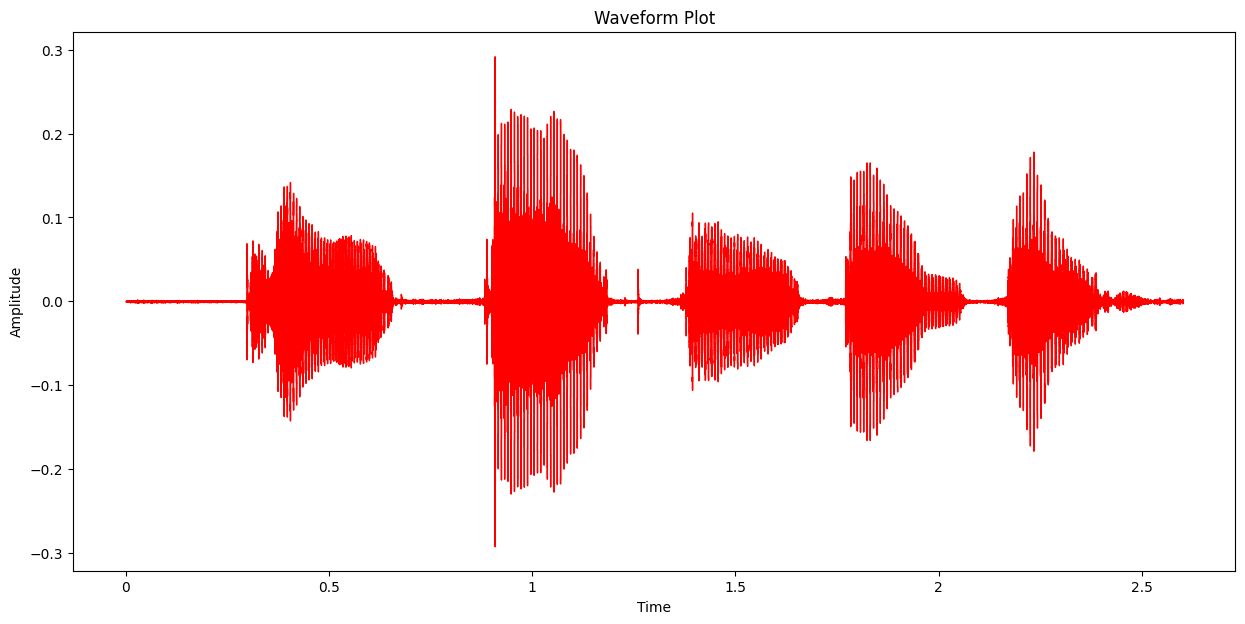

In [4]:
import librosa.display
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"]=(15, 7)
plt.title("Waveform Plot")
plt.ylabel("Amplitude")

_=librosa.display.waveshow(audio, color='red')

5. Display the spectrogram to take the frequency into consideration as well

Text(0.5, 1.0, 'Audio Spectrogram')

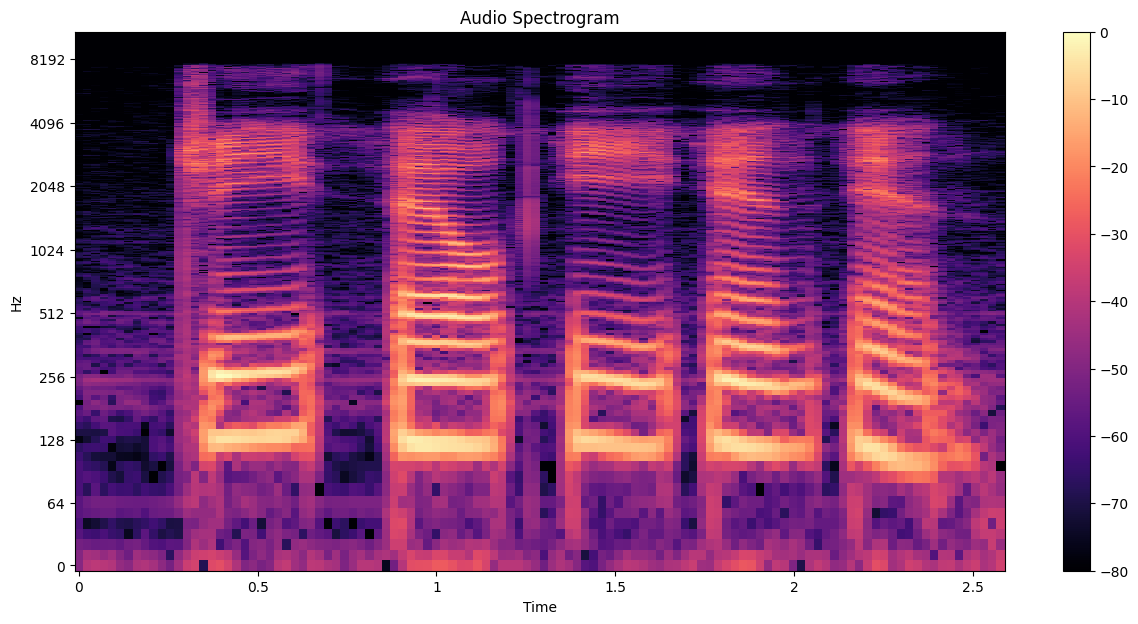

In [5]:
import numpy as np

spec=np.abs(librosa.stft(audio))
spec_db=librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title("Audio Spectrogram")

6. Mels spectrogram: Spectrogram that depicts more similar to how humans percieve

Text(0.5, 1.0, 'Mel spectrogram')

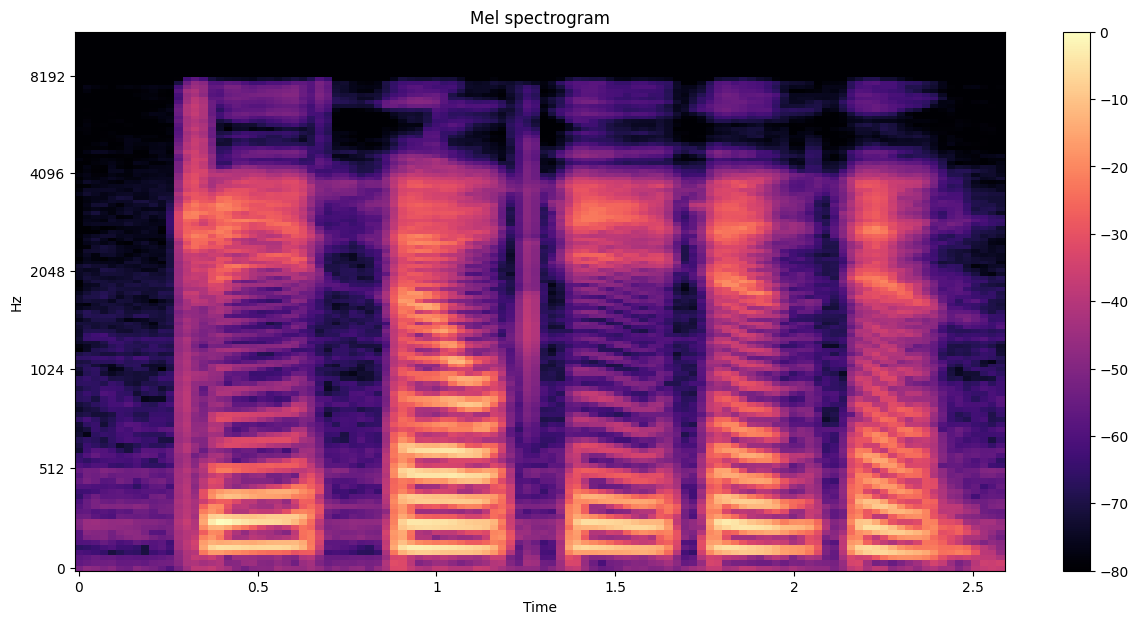

In [6]:
mel_spec=librosa.feature.melspectrogram(y=audio,sr=sample_rate)
mel_spec_db=librosa.power_to_db(mel_spec,ref=np.max)
librosa.display.specshow(mel_spec_db, y_axis='mel', x_axis='time')
plt.colorbar()
plt.title('Mel spectrogram')

In [7]:
import nemo
print(nemo.__version__)

import nemo.collections.asr as nemo_asr

2.0.0


In [8]:
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2024-12-16 08:02:47 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/QuartzNet15x5Base-En.nemo to /root/.cache/torch/NeMo/NeMo_2.0.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2024-12-16 08:02:47 common:826] Instantiating model from pre-trained checkpoint
[NeMo I 2024-12-16 08:02:49 features:305] PADDING: 16


[NeMo W 2024-12-16 08:02:50 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/nemo/core/connectors/save_restore_connector.py:682: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

[NeMo I 2024-12-16 08:02:50 save_restore_connector:275] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_2.0.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


In [9]:
files = [os.path.join(data_dir, 'an4/wav/an4_clstk/mgah/cen2-mgah-b.wav')]
for fname, transcription in zip(files, quartznet.transcribe(audio=files)):
  print(f"Audio in {fname} was recognized as: {transcription}")

Transcribing: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]

Audio in /content/drive/My Drive/an4/an4/wav/an4_clstk/mgah/cen2-mgah-b.wav was recognized as: g l e n n


To train our own model. In nemo t takes the manifest in a specific format:{"audio_filepath": "path/to/audio.wav", "duration": 3.45, "text": "this is a nemo tutorial"}. Therefore we irst create this from the transcription files in the etc for AN4 dataset.

In [10]:
import json
def createManifest(transcript_path, manifest_path, wav_path):
  with open(transcript_path,'r') as fin:
    with open(manifest_path,'w') as fout:
      for line in fin:
        transcript = line[0:line.find('(')-1].lower()
        transcript=transcript.replace('<s>',"").replace('</s>',"")
        transcript=transcript.strip()

        file_id=line[line.find('(')+1:-2]
        audioPath=os.path.join(wav_path,file_id[file_id.find('-')+1:file_id.rfind('-')],file_id+ '.wav')
        # print("audiopath:",audioPath)

        duration=librosa.core.get_duration(filename=audioPath)

        metadata={
            "audio_filepath":audioPath,
            "duration":duration,
            "text":transcript
        }
        fout.write(json.dumps(metadata)+"\n")


print('*********')
transcript_path=data_dir+'/an4/etc/an4_train.transcription'
# print("transpath:",transcript_path)
manifest_path=data_dir+'/an4/train_manifest.json'
wav_path=data_dir+'/an4/wav/an4_clstk'
if not os.path.isfile(manifest_path):
  createManifest(transcript_path,manifest_path,wav_path)
  print("Training manifest created.")
else:
  print("Training manifest already exists")


*********
Training manifest already exists


To create vaidation/test manifest

In [11]:
test_transcript_path=data_dir+'/an4/etc/an4_test.transcription'
test_manifest_path=data_dir+'/an4/test_manifest.json'
test_wav_path=data_dir+'/an4/wav/an4test_clstk'
if not os.path.isfile(test_manifest_path):
  createManifest(test_transcript_path, test_manifest_path, test_wav_path)
  print("validation maniest created successfully")
else:
  print("validation manifest already exists")

validation manifest already exists


In [12]:
from ruamel.yaml import YAML
yaml=YAML(typ='safe')
config_path=data_dir+'/configs/config.yaml'
with open(config_path) as f:
  params=yaml.load(f);
print(params)

{'name': 'QuartzNet15x5', 'sample_rate': 16000, 'repeat': 1, 'dropout': 0.0, 'separable': True, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'model': {'train_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch_size': 32, 'trim_silence': True, 'max_duration': 16.7, 'shuffle': True, 'num_workers': 8, 'pin_memory': True, 'is_tarred': False, 'tarred_audio_filepaths': None, 'shuffle_n': 2048, 'bucketing_strategy': 'synced_randomized', 'bucketing_batch_size': None}, 'validation_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch_size': 32, 'shuffle': False, 'num_work

Create the model and load the parameters from the config file

In [13]:
import pytorch_lightning as pl
from omegaconf import DictConfig
trainer=pl.Trainer(devices=1, accelerator='gpu', max_epochs=50)
params['model']['train_ds']['manifest_filepath']=manifest_path
params['model']['validation_ds']['manifest_filepath']=test_manifest_path
first_model=nemo_asr.models.EncDecCTCModel(cfg=DictConfig(params['model']), trainer=trainer)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


[NeMo I 2024-12-16 08:02:53 audio_to_text_dataset:49] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2024-12-16 08:02:53 audio_to_text_dataset:49] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2024-12-16 08:02:53 collections:196] Dataset loaded with 948 files totalling 0.71 hours
[NeMo I 2024-12-16 08:02:53 collections:197] 0 files were filtered totalling 0.00 hours


[NeMo W 2024-12-16 08:02:53 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      warnings.warn(
    


[NeMo I 2024-12-16 08:02:53 audio_to_text_dataset:49] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2024-12-16 08:02:53 audio_to_text_dataset:49] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2024-12-16 08:02:54 collections:196] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2024-12-16 08:02:54 collections:197] 0 files were filtered totalling 0.00 hours
[NeMo I 2024-12-16 08:02:54 features:305] PADDING: 16


Run the training of the model

In [14]:
# Uncomment only if you want to train again
# trainer.fit(first_model)


In [15]:
# trainer.save_checkpoint(data_dir+"/an4/model_checkpoint.ptl")

In [16]:
checkpoint_path=data_dir+'/an4/checkpoint.ckpt'
# first_model.save_to(checkpoint_path)
# print(f"Model saved successfully to {checkpoint_path}")

In [17]:
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/

In [18]:
first_model_trained = nemo_asr.models.EncDecCTCModel.restore_from(restore_path=checkpoint_path)

[NeMo W 2024-12-16 08:02:57 modelPT:176] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /content/drive/My Drive/an4/an4/train_manifest.json
    sample_rate: 16000
    labels:
    - ' '
    - a
    - b
    - c
    - d
    - e
    - f
    - g
    - h
    - i
    - j
    - k
    - l
    - m
    - 'n'
    - o
    - p
    - q
    - r
    - s
    - t
    - u
    - v
    - w
    - x
    - 'y'
    - z
    - ''''
    batch_size: 32
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    num_workers: 8
    pin_memory: true
    is_tarred: false
    tarred_audio_filepaths: null
    shuffle_n: 2048
    bucketing_strategy: synced_randomized
    bucketing_batch_size: null
    
[NeMo W 2024-12-16 08:02:57 modelPT:183] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2024-12-16 08:02:57 features:305] PADDING: 16


[NeMo W 2024-12-16 08:02:57 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/nemo/core/connectors/save_restore_connector.py:682: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

[NeMo I 2024-12-16 08:02:57 save_restore_connector:275] Model EncDecCTCModel was successfully restored from /content/drive/My Drive/an4/an4/checkpoint.ckpt.


Inference Model

In [19]:

audio = [os.path.join(data_dir, 'an4/wav/an4_clstk/mgah/cen2-mgah-b.wav'),
                     os.path.join(data_dir, 'an4/wav/an4_clstk/fmjd/cen7-fmjd-b.wav'),
                     os.path.join(data_dir, 'an4/wav/an4_clstk/fmjd/cen8-fmjd-b.wav'),
                     os.path.join(data_dir, 'an4/wav/an4_clstk/fkai/cen8-fkai-b.wav')]
print(first_model_trained.transcribe(audio=audio,
                                 batch_size=4))
# print(first_model_trained.input_spec)


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

['g l  n n', 'four two one h one in six', 'seven fourten sixty one', 'october fir nineteen sixty ne']


In [21]:
# !pip install onnxscript
# import torch.onnx

# input_tensor = torch.rand((1, 1, 128, 128), dtype=torch.float32)

# torch.onnx.export(
#     first_model_trained,                  # model to export
#     (input_tensor,),        # inputs of the model,
#     "my_model.onnx",        # filename of the ONNX model
#     input_names=["input"],  # Rename inputs for the ONNX model
#     dynamo=True             # True or False to select the exporter to use
# )

In [25]:
params['model']['batch_size']=16
first_model_trained.setup_test_data(test_data_config=params['model']['validation_ds'])

wer_nums=[]
wer_dens=[]

for test_batch in first_model_trained.test_dataloader():
  test_batch=[x.cuda() for x in test_batch] #each element of this batch is moved to gpu for faster computation
  targets=test_batch[2]
  targets_lengths=test_batch[3]
  log_probs, encoded_len, greedy_predictions=first_model_trained(input_signal=test_batch[0], input_signal_length=test_batch[1])
  first_model_trained.wer.update(predictions=greedy_predictions, predictions_lengths=None, targets=targets, targets_lengths=targets_lengths)
  _,wer_num, wer_den=first_model_trained.wer.compute()
  first_model_trained.wer.reset()
  wer_nums.append(wer_num.detach().cpu().numpy())
  wer_dens.append(wer_den.detach().cpu().numpy())
  del test_batch, log_probs, targets, targets_lengths, encoded_len, greedy_predictions

# We need to sum all numerators and denominators first. Then divide.
print(f"WER = {sum(wer_nums)/sum(wer_dens)}")


[NeMo I 2024-12-16 08:48:33 audio_to_text_dataset:49] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2024-12-16 08:48:33 audio_to_text_dataset:49] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2024-12-16 08:48:33 collections:196] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2024-12-16 08:48:33 collections:197] 0 files were filtered totalling 0.00 hours


[NeMo W 2024-12-16 08:48:33 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      warnings.warn(
    


WER = 0.592496765847348
